## Multi-label Disease Classification of Chest X-Ray Images
#### UC San Diego Machine Learning Engineering Bootcamp
Tung Nguyen

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

### Data Wrangling
---

In [3]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Iterative Train/Test Split with sklearn
---

In [4]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [5]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

In [6]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title, fontsize=16);
    ax.set_xlabel('Labels', fontsize=12);
    ax.set_ylabel('Frequency', fontsize=12);

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')

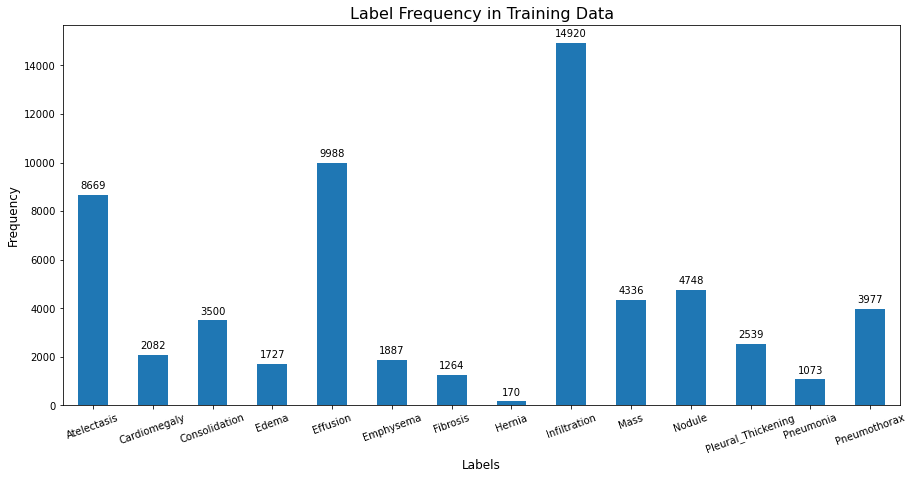

In [7]:
plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data')

### Data Sampling
---

In [8]:
sampled_train_df = pd.DataFrame([])

n = 1500

for lbl in labels:
    temp = train_df[train_df[lbl] == 1].sample(
        n,
        replace=True,
        random_state=random_state
    )
    
    sampled_train_df = pd.concat([sampled_train_df, temp])
    
temp = train_df[train_df['Finding Labels'] == ''].sample(
    n,
    replace=False,
    random_state=random_state
)
sampled_train_df = pd.concat([sampled_train_df, temp])

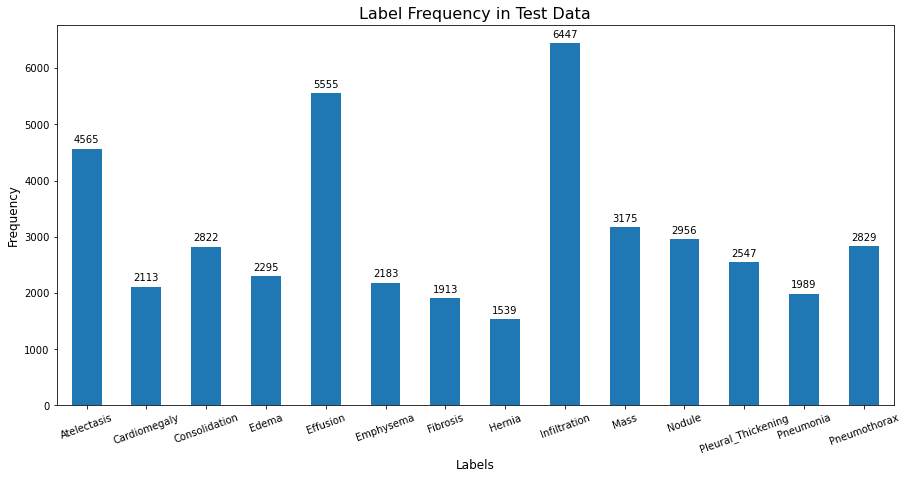

In [9]:
plot_df_freq(sampled_train_df, labels, offset=100, title='Label Frequency in Test Data')

### Data Generators
---

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, sample_norm=True, target_size=(256, 256), 
                    val_split=0.2, batch_size=64, color_mode='rgb', weight_col=None):

    datagen = ImageDataGenerator(
        samplewise_center=sample_norm,
        samplewise_std_normalization=sample_norm, 
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
        validation_split=val_split
    )

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation'
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols
    )
    
    return train_generator, validation_generator, test_generator

In [12]:
data_dir = '/Users/tungnguyen/Documents/capstone/data/'

### VGG16 Trade Studies
---

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix

In [14]:
def plot_losses(model_history):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss', fontsize=18, fontweight='bold')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def plot_roc_auc(y_pred, test_df, labels, model_name):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name, fontsize=18, fontweight='bold');
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name, fontsize=18, fontweight='bold');
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

In [15]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)


early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.001
)

2022-01-16 21:21:43.488506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-16 21:21:43.488647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


In [16]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=train_df[lbl]))))

weights

[{0: 0.5574730170516322, 1: 4.849867343407544},
 {0: 0.5126943479056155, 1: 20.193804034582133},
 {0: 0.5217156613349547, 1: 12.012428571428572},
 {0: 0.5104844584749879, 1: 24.344817602779386},
 {0: 0.567396321137937, 1: 4.209401281537845},
 {0: 0.5114781021897811, 1: 22.28060413354531},
 {0: 0.5076307305941586, 1: 33.26226265822785},
 {0: 0.5010129056091137, 1: 247.31470588235294},
 {0: 0.6078549019040872, 1: 2.8179289544235924},
 {0: 0.5271846121051774, 1: 9.696379151291513},
 {0: 0.5299222324455816, 1: 8.854991575400168},
 {0: 0.5155675185167018, 1: 16.559078377313902},
 {0: 0.5064627653166935, 1: 39.183131407269336},
 {0: 0.5248221195855698, 1: 10.571662056826753}]

In [17]:
# Class weights for weighted loss
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1] / sum(d.values()))
    neg = np.append(neg, d[0] / sum(d.values())) 

print(pos)
print(neg)

[0.8969044  0.97523993 0.95837644 0.97946175 0.88121826 0.97755896
 0.98496795 0.99797828 0.82256472 0.94843436 0.94353467 0.96980508
 0.98723941 0.95270375]
[0.1030956  0.02476007 0.04162356 0.02053825 0.11878174 0.02244104
 0.01503205 0.00202172 0.17743528 0.05156564 0.05646533 0.03019492
 0.01276059 0.04729625]


In [18]:
from tensorflow.keras import backend as K

def get_weighted_loss(pos, neg, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos)):
            loss += -1 * K.mean(pos * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg * K.log(1 - y_pred + epsilon))      
        return loss
    return weighted_loss

#### VGG16 - Custom Loss + Sampled DataFrame - with initial layers frozen
----
* Data was sampled to get better class balance (e.g. Hernia has significantly less instances than other classes, ~150 pts in train_df)
* Best overall model from previous studies was custom loss + samplewise normalization + data augmentation

In [19]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 28030 validated image filenames.


In [20]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)

for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [21]:
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
2,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
3,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
5,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
6,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False
9,<keras.layers.pooling.MaxPooling2D object at 0...,block3_pool,False


In [22]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics=['accuracy']
)

In [23]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-initial-frozen.h5'

weighted_loss_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [24]:
%%time
weighted_loss_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_chkpt, early, reduce_lr]
)

2022-01-16 21:21:47.157713: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2022-01-16 21:21:47.696471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 1.2548 - accuracy: 0.0685

2022-01-16 21:26:51.274803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.54066, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-initial-frozen.h5
282/282 [==============================] - 378s 1s/step - loss: 1.2548 - accuracy: 0.0685 - val_loss: 1.5407 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 1.1689 - accuracy: 0.1025
Epoch 00002: val_loss did not improve from 1.54066
282/282 [==============================] - 372s 1s/step - loss: 1.1689 - accuracy: 0.1025 - val_loss: 1.5498 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.1133
Epoch 00003: val_loss did not improve from 1.54066
282/282 [==============================] - 374s 1s/step - loss: 1.1582 - accuracy: 0.1133 - val_loss: 1.5445 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/40
282/282 [==============================] - ETA: 0s - loss: 1.1453 - accuracy: 0.1228
Epoch 000

282/282 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.1633
Epoch 00027: val_loss did not improve from 1.41801
282/282 [==============================] - 366s 1s/step - loss: 1.0828 - accuracy: 0.1633 - val_loss: 1.5176 - val_accuracy: 0.0013 - lr: 0.0010
Epoch 28/40
282/282 [==============================] - ETA: 0s - loss: 1.0740 - accuracy: 0.1651
Epoch 00028: val_loss did not improve from 1.41801
282/282 [==============================] - 366s 1s/step - loss: 1.0740 - accuracy: 0.1651 - val_loss: 1.7040 - val_accuracy: 8.8889e-04 - lr: 0.0010
Epoch 29/40
282/282 [==============================] - ETA: 0s - loss: 1.0611 - accuracy: 0.1687
Epoch 00029: val_loss did not improve from 1.41801
282/282 [==============================] - 366s 1s/step - loss: 1.0611 - accuracy: 0.1687 - val_loss: 1.5894 - val_accuracy: 0.0051 - lr: 0.0010
CPU times: user 2h 53min 55s, sys: 18min 27s, total: 3h 12min 23s
Wall time: 2h 57min 30s


In [25]:
y_pred_weighted_loss_frozen = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-17 00:19:17.921079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 459s 1s/step


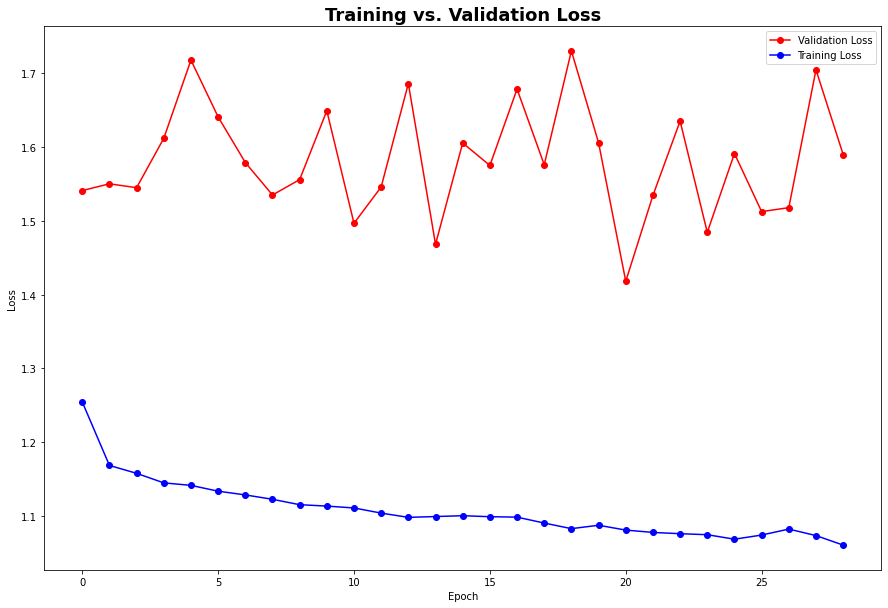

In [26]:
plot_losses(weighted_loss_history)

AUC = 0.7217 for Atelectasis
AUC = 0.7251 for Cardiomegaly
AUC = 0.7242 for Consolidation
AUC = 0.8558 for Edema
AUC = 0.8136 for Effusion
AUC = 0.7530 for Emphysema
AUC = 0.6240 for Fibrosis
AUC = 0.8495 for Hernia
AUC = 0.6738 for Infiltration
AUC = 0.5958 for Mass
AUC = 0.6000 for Nodule
AUC = 0.6619 for Pleural_Thickening
AUC = 0.6508 for Pneumonia
AUC = 0.7415 for Pneumothorax


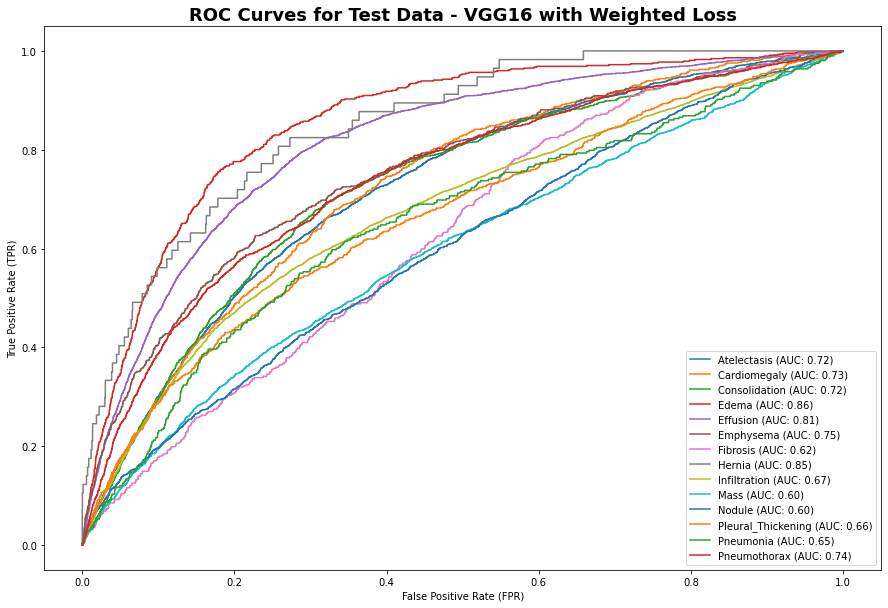

In [27]:
plot_roc_auc(y_pred_weighted_loss_frozen, test_df, labels, model_name='VGG16 with Weighted Loss')

AUC = 0.2197 for Atelectasis
AUC = 0.0617 for Cardiomegaly
AUC = 0.0946 for Consolidation
AUC = 0.1093 for Edema
AUC = 0.3691 for Effusion
AUC = 0.0898 for Emphysema
AUC = 0.0230 for Fibrosis
AUC = 0.0889 for Hernia
AUC = 0.3161 for Infiltration
AUC = 0.0780 for Mass
AUC = 0.0909 for Nodule
AUC = 0.0636 for Pleural_Thickening
AUC = 0.0250 for Pneumonia
AUC = 0.1346 for Pneumothorax


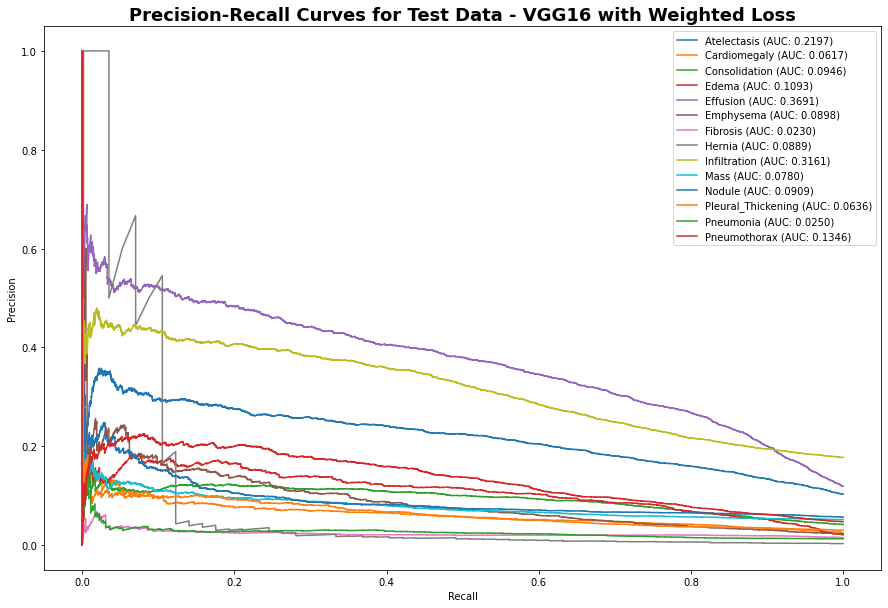

In [28]:
plot_precision_recall_auc(y_pred_weighted_loss_frozen, test_df, labels, model_name='VGG16 with Weighted Loss')

#### VGG16 - Custom Loss + Sampled DataFrame - with no layers frozen
----
* Data was sampled to get better class balance (e.g. Hernia has significantly less instances than other classes, ~150 pts in train_df)
* Best overall model from previous studies was custom loss + samplewise normalization + data augmentation

In [29]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 28030 validated image filenames.


In [30]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [31]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics=['accuracy']
)

In [32]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-unfrozen.h5'

weighted_loss_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [33]:
%%time
weighted_loss_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-17 00:26:59.500309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 1.2608 - accuracy: 0.0580

2022-01-17 00:33:53.991785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.60223, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-unfrozen.h5
282/282 [==============================] - 489s 2s/step - loss: 1.2608 - accuracy: 0.0580 - val_loss: 1.6022 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 1.2408 - accuracy: 0.0579
Epoch 00002: val_loss did not improve from 1.60223
282/282 [==============================] - 485s 2s/step - loss: 1.2408 - accuracy: 0.0579 - val_loss: 1.6407 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 1.2396 - accuracy: 0.0579
Epoch 00003: val_loss did not improve from 1.60223
282/282 [==============================] - 485s 2s/step - loss: 1.2396 - accuracy: 0.0579 - val_loss: 1.6485 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/40
282/282 [==============================] - ETA: 0s - loss: 1.2354 - accuracy: 0.0579
Epoch 00004: va

In [34]:
y_pred_weighted_loss_unfrozen = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-17 02:52:27.162242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 457s 1s/step


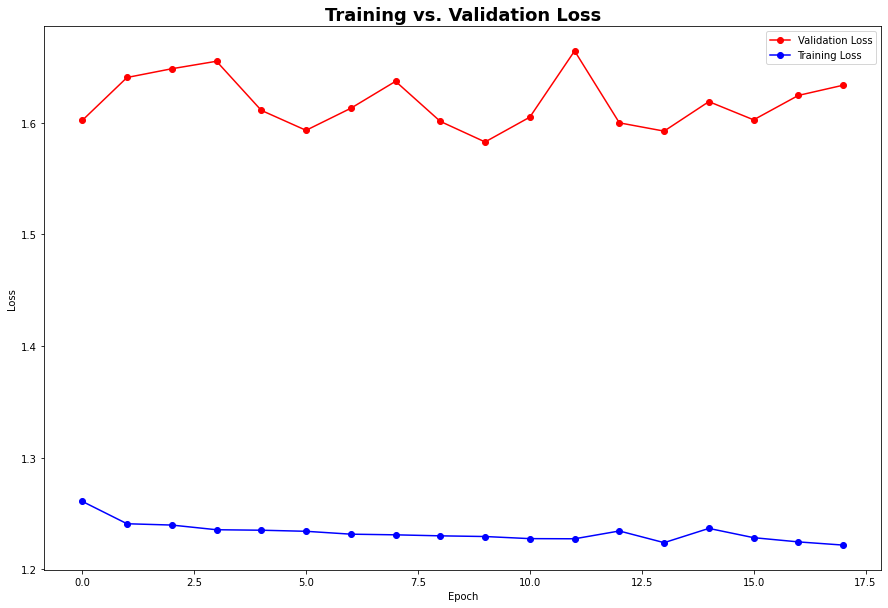

In [35]:
plot_losses(weighted_loss_history)

AUC = 0.6260 for Atelectasis
AUC = 0.5572 for Cardiomegaly
AUC = 0.6687 for Consolidation
AUC = 0.7161 for Edema
AUC = 0.6681 for Effusion
AUC = 0.6033 for Emphysema
AUC = 0.4315 for Fibrosis
AUC = 0.3994 for Hernia
AUC = 0.6230 for Infiltration
AUC = 0.5386 for Mass
AUC = 0.4695 for Nodule
AUC = 0.5368 for Pleural_Thickening
AUC = 0.5982 for Pneumonia
AUC = 0.5830 for Pneumothorax


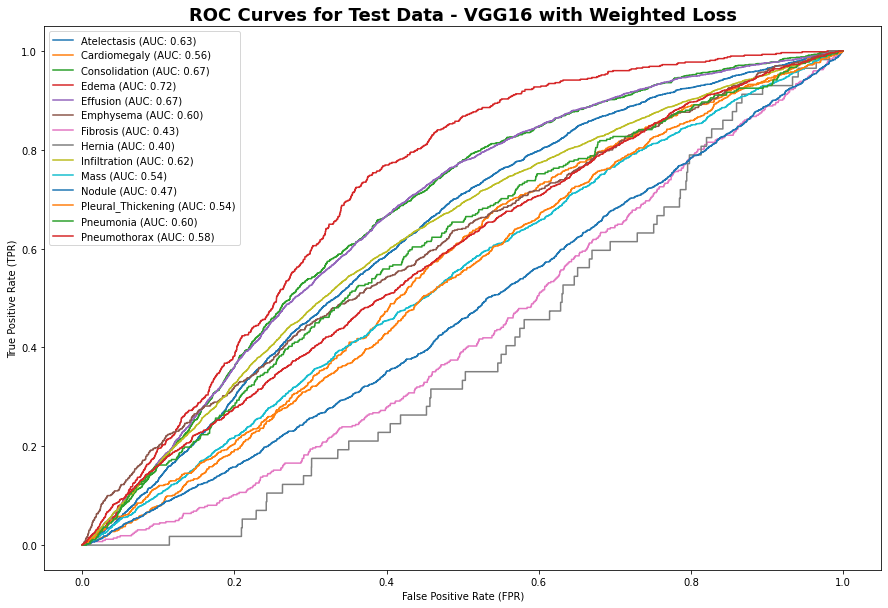

In [36]:
plot_roc_auc(y_pred_weighted_loss_unfrozen, test_df, labels, model_name='VGG16 with Weighted Loss')

AUC = 0.1348 for Atelectasis
AUC = 0.0266 for Cardiomegaly
AUC = 0.0644 for Consolidation
AUC = 0.0363 for Edema
AUC = 0.1771 for Effusion
AUC = 0.0353 for Emphysema
AUC = 0.0120 for Fibrosis
AUC = 0.0015 for Hernia
AUC = 0.2367 for Infiltration
AUC = 0.0554 for Mass
AUC = 0.0509 for Nodule
AUC = 0.0326 for Pleural_Thickening
AUC = 0.0168 for Pneumonia
AUC = 0.0619 for Pneumothorax


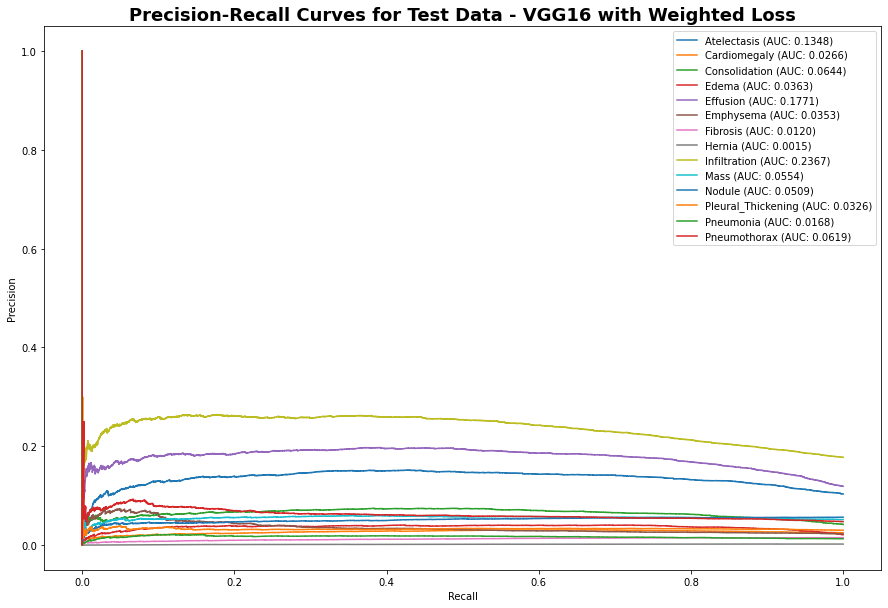

In [37]:
plot_precision_recall_auc(y_pred_weighted_loss_unfrozen, test_df, labels, model_name='VGG16 with Weighted Loss')

#### Store Variables

In [38]:
%store y_pred_weighted_loss_frozen
%store y_pred_weighted_loss_unfrozen

Stored 'y_pred_weighted_loss_frozen' (ndarray)
Stored 'y_pred_weighted_loss_unfrozen' (ndarray)


#### VGG16 - Custom Loss Baseline - with initial layers frozen
---

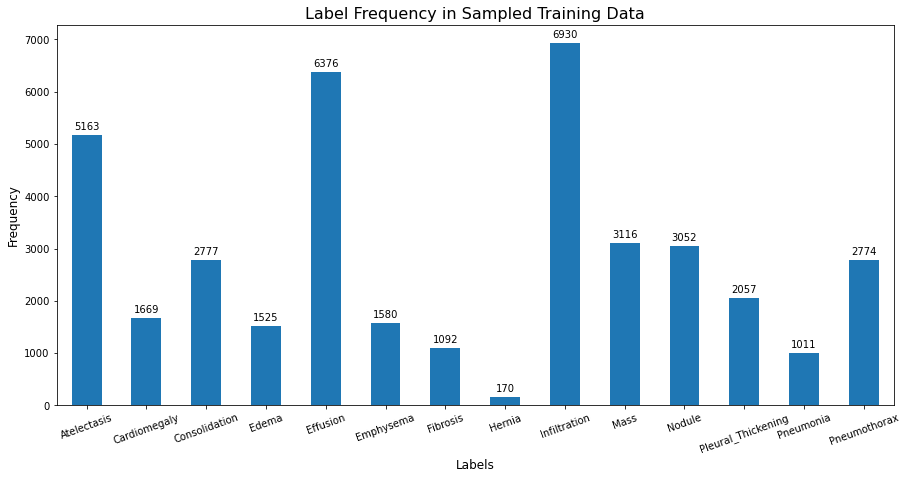

In [39]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])

sampled_train_df2 = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df2, labels, offset=100, title='Label Frequency in Sampled Training Data')

In [40]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df2, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [41]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [42]:
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
2,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
3,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
5,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
6,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False
9,<keras.layers.pooling.MaxPooling2D object at 0...,block3_pool,False


In [43]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics=['accuracy']
)

In [44]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-baseline-frozen.h5'

weighted_loss_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [45]:
%%time
weighted_loss_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-17 03:00:08.154179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2416 - accuracy: 0.0696

2022-01-17 03:04:35.738654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.56979, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-baseline-frozen.h5
250/250 [==============================] - 334s 1s/step - loss: 1.2416 - accuracy: 0.0696 - val_loss: 1.5698 - val_accuracy: 0.0948 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.2331 - accuracy: 0.0721
Epoch 00002: val_loss improved from 1.56979 to 1.56632, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-baseline-frozen.h5
250/250 [==============================] - 332s 1s/step - loss: 1.2331 - accuracy: 0.0721 - val_loss: 1.5663 - val_accuracy: 0.1223 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.2337 - accuracy: 0.0741
Epoch 00003: val_loss improved from 1.56632 to 1.50088, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-baseline-frozen.h5
250/250 [==============================] - 333s

In [46]:
y_pred_weighted_loss_baseline_frozen = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-17 04:06:49.790726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 459s 1s/step


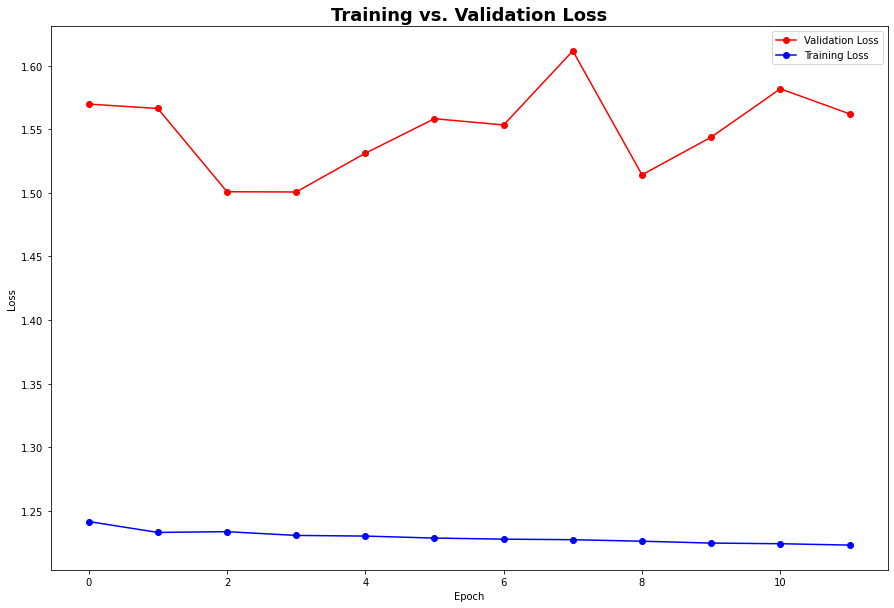

In [47]:
plot_losses(weighted_loss_history)

AUC = 0.6283 for Atelectasis
AUC = 0.5577 for Cardiomegaly
AUC = 0.6846 for Consolidation
AUC = 0.7301 for Edema
AUC = 0.6745 for Effusion
AUC = 0.5809 for Emphysema
AUC = 0.5479 for Fibrosis
AUC = 0.4154 for Hernia
AUC = 0.6261 for Infiltration
AUC = 0.5321 for Mass
AUC = 0.4751 for Nodule
AUC = 0.5316 for Pleural_Thickening
AUC = 0.6111 for Pneumonia
AUC = 0.5862 for Pneumothorax


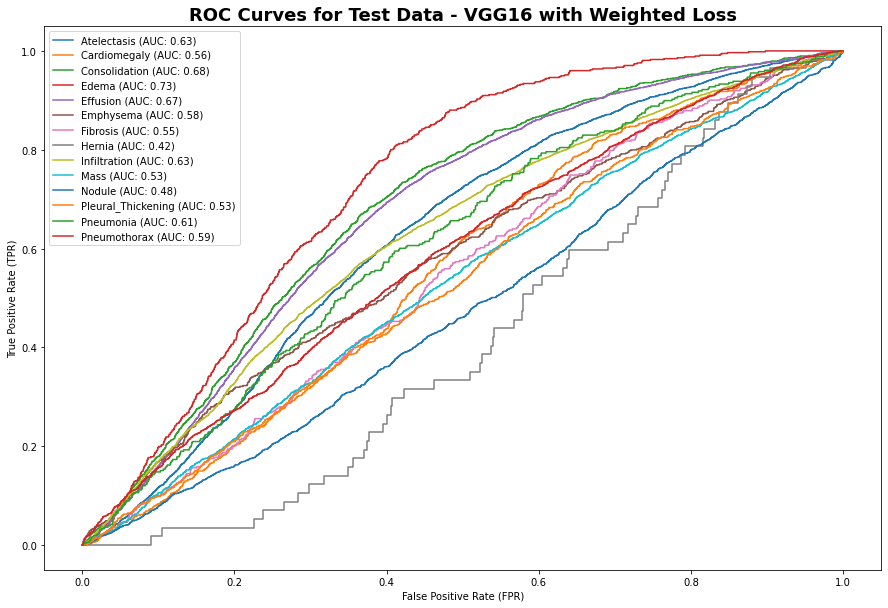

In [48]:
plot_roc_auc(y_pred_weighted_loss_baseline_frozen, test_df, labels, model_name='VGG16 with Weighted Loss')

AUC = 0.1330 for Atelectasis
AUC = 0.0267 for Cardiomegaly
AUC = 0.0686 for Consolidation
AUC = 0.0378 for Edema
AUC = 0.1768 for Effusion
AUC = 0.0309 for Emphysema
AUC = 0.0163 for Fibrosis
AUC = 0.0016 for Hernia
AUC = 0.2386 for Infiltration
AUC = 0.0544 for Mass
AUC = 0.0515 for Nodule
AUC = 0.0318 for Pleural_Thickening
AUC = 0.0171 for Pneumonia
AUC = 0.0634 for Pneumothorax


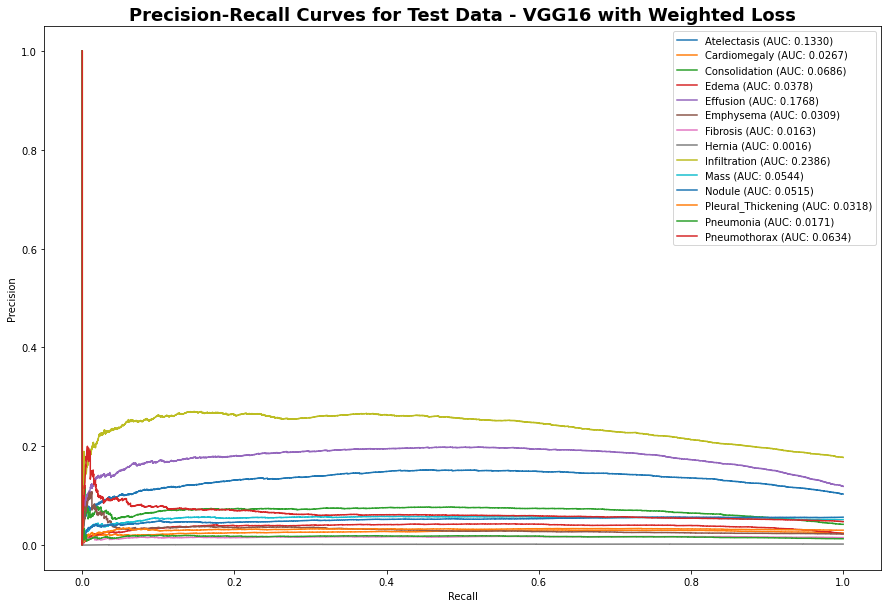

In [49]:
plot_precision_recall_auc(y_pred_weighted_loss_baseline_frozen, test_df, labels, model_name='VGG16 with Weighted Loss')

#### VGG16 - Custom Loss Baseline - with no layers frozen, with no class weight normalization
---

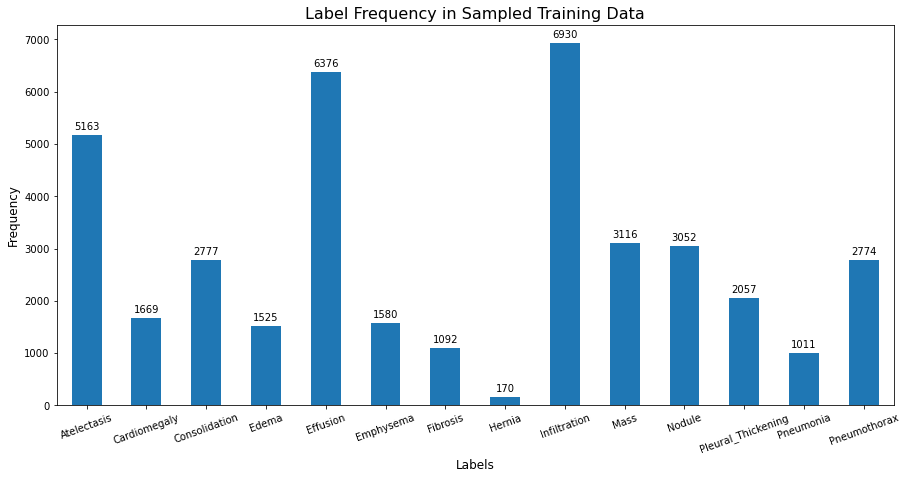

In [50]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])

sampled_train_df2 = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df2, labels, offset=100, title='Label Frequency in Sampled Training Data')

In [51]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df2, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [52]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [53]:
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
2,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
3,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
5,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
6,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False
9,<keras.layers.pooling.MaxPooling2D object at 0...,block3_pool,False


In [54]:
# Class weights for weighted loss
pos2 = np.array([])
neg2 = np.array([])
for d in weights:
    pos2 = np.append(pos2, d[1])
    neg2 = np.append(neg2, d[0]) 

print(pos2)
print(neg2)

[  4.84986734  20.19380403  12.01242857  24.3448176    4.20940128
  22.28060413  33.26226266 247.31470588   2.81792895   9.69637915
   8.85499158  16.55907838  39.18313141  10.57166206]
[0.55747302 0.51269435 0.52171566 0.51048446 0.56739632 0.5114781
 0.50763073 0.50101291 0.6078549  0.52718461 0.52992223 0.51556752
 0.50646277 0.52482212]


In [55]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos2, neg2),
    metrics=['accuracy']
)

In [56]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-baseline-frozen-2.h5'

weighted_loss_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [57]:
%%time
weighted_loss_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-17 04:14:31.557961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 14.2945 - accuracy: 0.0608

2022-01-17 04:18:59.017986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 22.01507, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-baseline-frozen-2.h5
250/250 [==============================] - 334s 1s/step - loss: 14.2945 - accuracy: 0.0608 - val_loss: 22.0151 - val_accuracy: 0.0367 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 14.1625 - accuracy: 0.0516
Epoch 00002: val_loss improved from 22.01507 to 21.20158, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-baseline-frozen-2.h5
250/250 [==============================] - 332s 1s/step - loss: 14.1625 - accuracy: 0.0516 - val_loss: 21.2016 - val_accuracy: 0.0367 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 14.1433 - accuracy: 0.0608
Epoch 00003: val_loss did not improve from 21.20158
250/250 [==============================] - 331s 1s/step - loss: 14.1433 - accuracy: 0.0608 - val_loss: 22.0053 - val_accuracy: 0.1015 - lr: 

In [58]:
y_pred_weighted_loss_baseline_frozen_2 = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-17 05:20:53.074434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 458s 1s/step


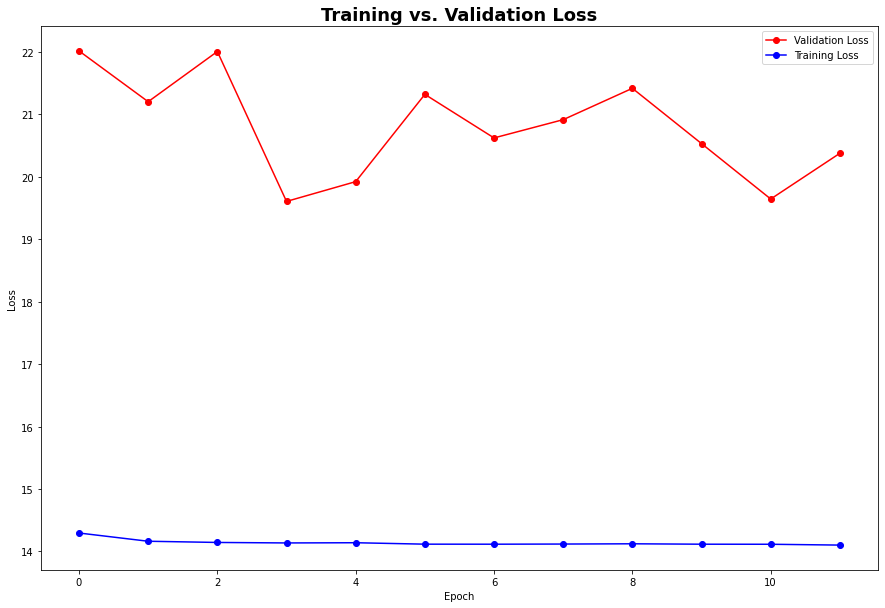

In [59]:
plot_losses(weighted_loss_history)

AUC = 0.5367 for Atelectasis
AUC = 0.5042 for Cardiomegaly
AUC = 0.5845 for Consolidation
AUC = 0.6112 for Edema
AUC = 0.5688 for Effusion
AUC = 0.5518 for Emphysema
AUC = 0.4567 for Fibrosis
AUC = 0.3884 for Hernia
AUC = 0.5621 for Infiltration
AUC = 0.4947 for Mass
AUC = 0.4650 for Nodule
AUC = 0.5055 for Pleural_Thickening
AUC = 0.5541 for Pneumonia
AUC = 0.5456 for Pneumothorax


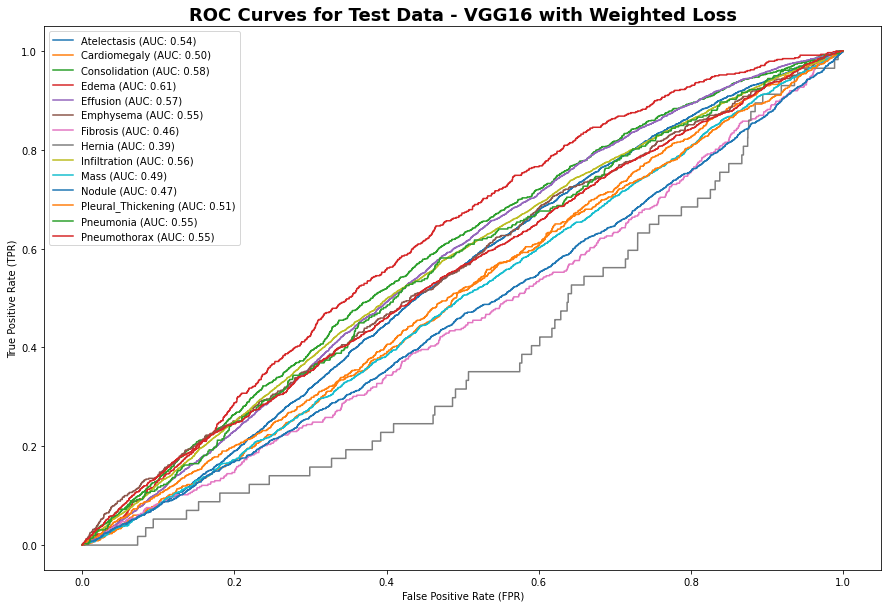

In [60]:
plot_roc_auc(y_pred_weighted_loss_baseline_frozen_2, test_df, labels, model_name='VGG16 with Weighted Loss')

AUC = 0.1062 for Atelectasis
AUC = 0.0239 for Cardiomegaly
AUC = 0.0522 for Consolidation
AUC = 0.0265 for Edema
AUC = 0.1338 for Effusion
AUC = 0.0279 for Emphysema
AUC = 0.0133 for Fibrosis
AUC = 0.0015 for Hernia
AUC = 0.2033 for Infiltration
AUC = 0.0491 for Mass
AUC = 0.0511 for Nodule
AUC = 0.0305 for Pleural_Thickening
AUC = 0.0149 for Pneumonia
AUC = 0.0560 for Pneumothorax


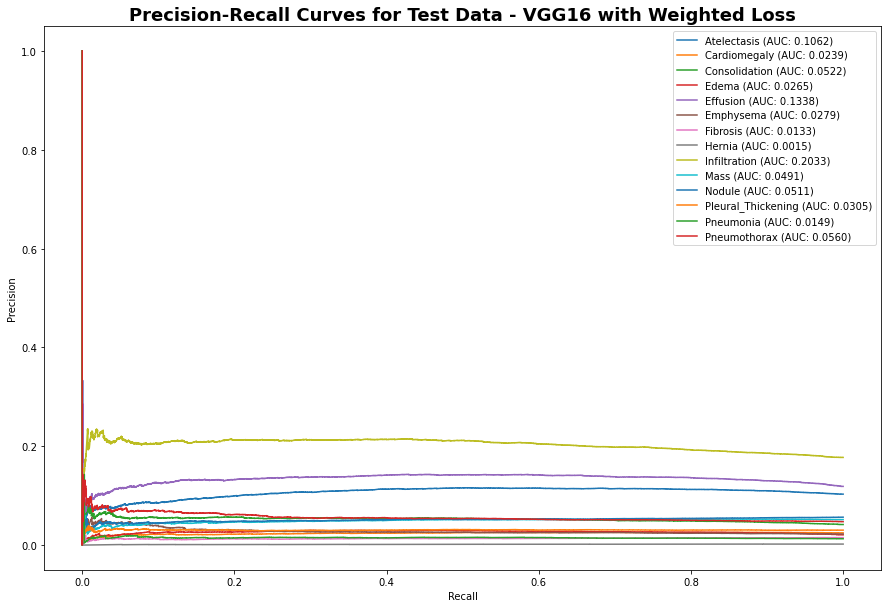

In [61]:
plot_precision_recall_auc(y_pred_weighted_loss_baseline_frozen_2, test_df, labels, model_name='VGG16 with Weighted Loss')